### ProteinFDR 0.01 PSM FDR 0.01

In [1]:
%load_ext rpy2.ipython

/home/qinchunyuan/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [44]:
# preprocess out_msstats.csv

import pandas as pd

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro:
        t = []
        for p in Pro.split(";"):
            if "CONTAMINANT" in p or "DECOY_" in p:
                pass
            else:
                t.append(p)
        if len(t) == 0:
            return None
        return ";".join(t)
    else:
        return Pro
    
data = pd.read_csv("../datasets/PXD020248/out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
data.dropna(inplace=True)
data.to_csv("../datasets/PXD020248/out_msstats_pre.csv", index=False, sep=",")

In [3]:
%%R -w 1600 -h 600
data_folder = '../datasets/PXD020248/analysis'
setwd(data_folder)

In [4]:
%%R -w 1600 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats_pre.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)


INFO  [2021-09-19 15:26:35] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-19 15:26:37] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-19 15:26:37] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-19 15:26:37] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-19 15:26:38] ** Shared peptides are removed.
INFO  [2021-09-19 15:26:38] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-19 15:26:44] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-19 15:26:46] ** For peptides overlapped between fractions of 1_1_1 use the fraction with maximal average abundance.
INFO  [2021-09-19 15:26:47] ** For peptides overl

### Protein summarization, normalization and visualization

INFO  [2021-09-19 21:54:14] ** MSstatsTMT - proteinSummarization function
INFO  [2021-09-19 21:54:15] Summarizing for Run : 2_2_2 ( 1  of  2 )
  |======================================================================| 100%
INFO  [2021-09-19 21:55:25] Summarizing for Run : 1_1_1 ( 2  of  2 )
  |======================================================================| 100%
INFO  [2021-09-19 21:56:33] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


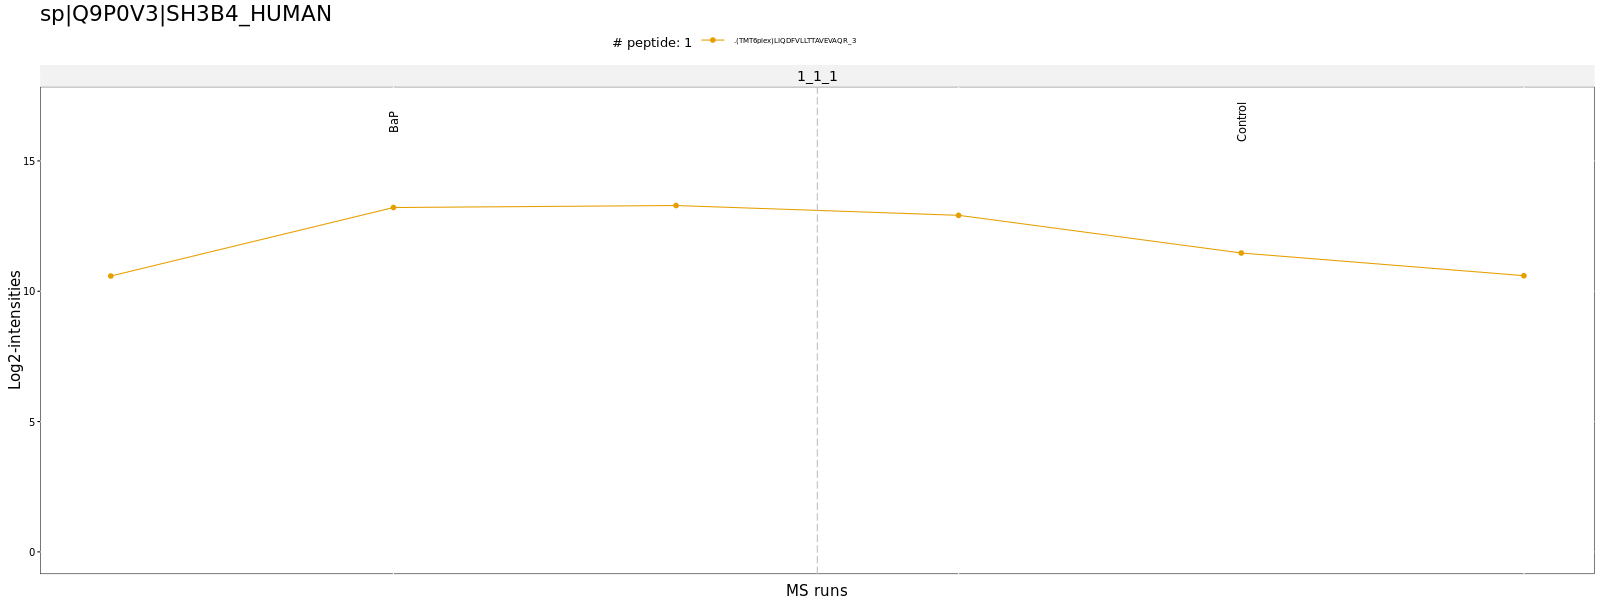

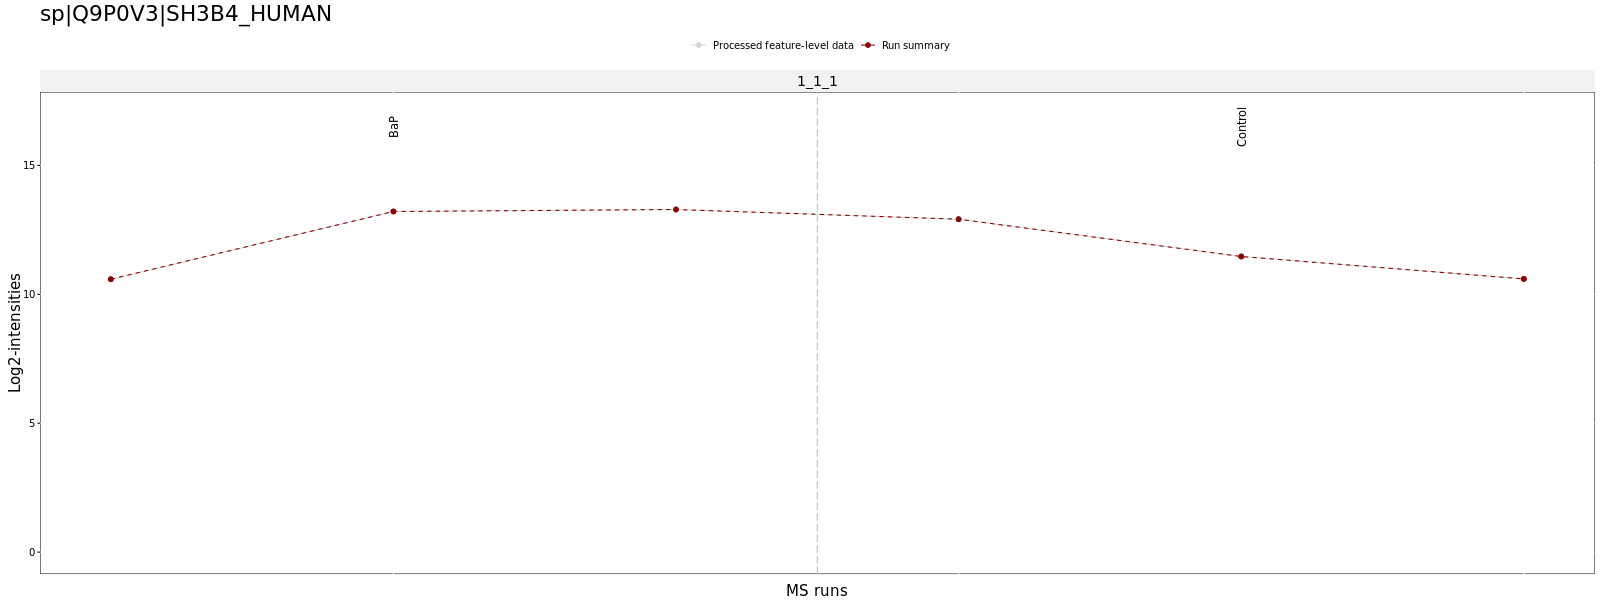

In [58]:
%%R -w 1600 -h 600

protein_expression = './protein_expression.csv'
# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|Q9P0V3|SH3B4_HUMAN',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)

TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'BioReplicate', 'Condition')]
write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

In [57]:
%%R

head(quant_om.msstats$ProteinLevelData)

  Mixture TechRepMixture   Run Channel               Protein Abundance
1       1            1_1 1_1_1       1  sp|A0AVT1|UBA6_HUMAN  17.01966
2       1            1_1 1_1_1       1 sp|A0MZ66|SHOT1_HUMAN  17.22401
3       1            1_1 1_1_1       1 sp|A1L0T0|HACL2_HUMAN  14.97292
4       1            1_1 1_1_1       1 sp|A1L170|CA226_HUMAN  16.01807
5       1            1_1 1_1_1       1 sp|A1L4H1|SRCRL_HUMAN  14.80599
6       1            1_1 1_1_1       1  sp|A2RRP1|NBAS_HUMAN  13.79380
  BioReplicate Condition
1            1   Control
2            1   Control
3            1   Control
4            1   Control
5            1   Control
6            1   Control


R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



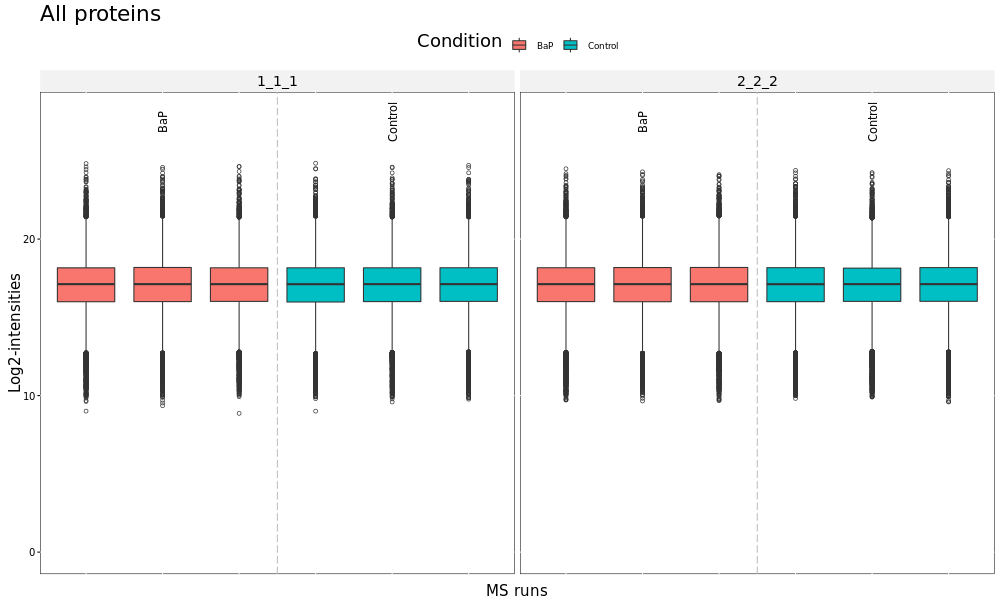

In [6]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [7]:
%%R

# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "BaP"     "Control"


In [8]:
%%R -w 1000 -h 600

TMT_Comp<-matrix(c(1, -1), nrow=1)
row.names(TMT_Comp)<-c("BaP vs Control")
colnames(TMT_Comp) = c("BaP","Control")
TMT_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = TMT_Comp, moderated = TRUE)
head(TMT_Comp.pairwise$ComparisonResult)

INFO  [2021-09-19 15:29:15] Model fitting for 4203 proteins.
  |======================================================================| 100%
INFO  [2021-09-19 15:31:31] Testing for 4203 proteins:
  |======================================================================| 100%
                 Protein          Label        log2FC         SE        DF
1: sp|A0AV96|RBM47_HUMAN BaP vs Control -0.0655552036 0.11680347  6.483777
2:  sp|A0AVT1|UBA6_HUMAN BaP vs Control  0.0464166007 0.03603064 11.483777
3: sp|A0FGR8|ESYT2_HUMAN BaP vs Control  0.1018342059 0.07024730  6.483777
4: sp|A0MZ66|SHOT1_HUMAN BaP vs Control -0.0006126335 0.06386193 11.483779
5: sp|A1L0T0|HACL2_HUMAN BaP vs Control  0.1450326358 0.10322933 11.483777
6: sp|A1L170|CA226_HUMAN BaP vs Control -0.0623892898 0.04749563 11.483777
      pvalue adj.pvalue issue
1: 0.5934870  0.8616324    NA
2: 0.2230091  0.6466952    NA
3: 0.1937424  0.6250457    NA
4: 0.9925106  0.9978382    NA
5: 0.1865033  0.6219275    NA
6: 0.2146260  0.645

In [18]:
%%R

TMT_Comp = TMT_Comp.pairwise$ComparisonResult
write.table(TMT_Comp,"BaP_Control_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

#### TMT pipeline quantifed more proteins than original result, and the most of proteins given in original result are in our result

<AxesSubplot:title={'center':'overlaping of the quantified proteins'}>

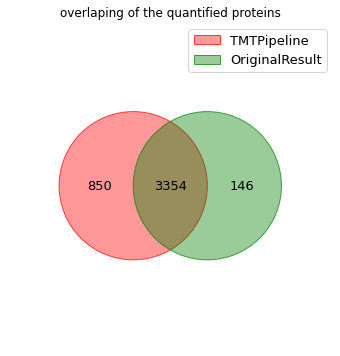

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from venn import venn

# read the original result
OriginalResult = pd.read_excel("./1-s2.0-S0300483X20302912-mmc2.xlsx", sheet_name="sTable 2", header=3)
TMTPipelineResult = pd.read_csv("./out_msstats_pre.csv", sep=",", header=0)
TMTPipelineResult["ProteinEntry"] = TMTPipelineResult.apply(lambda x: x.ProteinName.split("|")[1], axis=1)

_, axs = plt.subplots(ncols=1,nrows=1, figsize=(6, 6))
axs.set_title("overlaping of the quantified proteins")
venn({"TMTPipeline": set(TMTPipelineResult["ProteinEntry"]), "OriginalResult": set(OriginalResult["Accession"])}, cmap=['r', 'g'], ax= axs)

### Visualization BaP vs Control Condition and Comparing DEP

                 Protein           Label    log2FC    pvalue  adj.pvalue  \
0  sp|A0AV96|RBM47_HUMAN  BaP vs Control -0.065555  0.593487    0.861632   
1   sp|A0AVT1|UBA6_HUMAN  BaP vs Control  0.046417  0.223009    0.646695   
2  sp|A0FGR8|ESYT2_HUMAN  BaP vs Control  0.101834  0.193742    0.625046   
3  sp|A0MZ66|SHOT1_HUMAN  BaP vs Control -0.000613  0.992511    0.997838   
4  sp|A1L0T0|HACL2_HUMAN  BaP vs Control  0.145033  0.186503    0.621928   

   -Log10(p-value)  
0         0.226589  
1         0.651677  
2         0.712775  
3         0.003265  
4         0.729314  
                 Protein           Label    log2FC    pvalue  adj.pvalue  \
0  sp|A0AV96|RBM47_HUMAN  BaP vs Control -0.065555  0.593487    0.861632   
1   sp|A0AVT1|UBA6_HUMAN  BaP vs Control  0.046417  0.223009    0.646695   
2  sp|A0FGR8|ESYT2_HUMAN  BaP vs Control  0.101834  0.193742    0.625046   
3  sp|A0MZ66|SHOT1_HUMAN  BaP vs Control -0.000613  0.992511    0.997838   
4  sp|A1L0T0|HACL2_HUMAN  BaP vs Cont

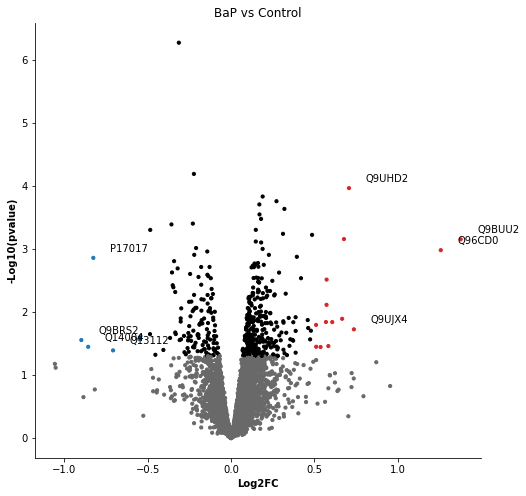

In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

result = pd.read_csv('./BaP_Control_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue', 'adj.pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])
print(result.head())
result["ProteinEntry"] = result.apply(lambda x: x.Protein.split("|")[1], axis=1)

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] >= 0.5)&(result['pvalue'] <= 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] <= -0.5)&(result['pvalue'] <= 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] > 0.05,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_title(comp)

    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 0.7)].iterrows():
        ax.annotate(row['ProteinEntry'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
    i += 1
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


#### It seem that We found more differential expressed proteins ！！！！

<AxesSubplot:title={'center':'overlaping of the differential expressed proteins '}>

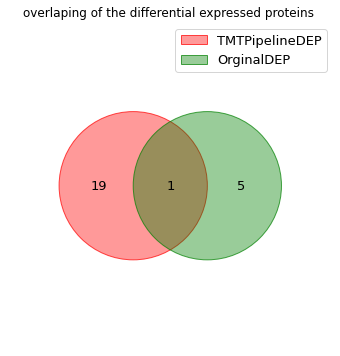

In [40]:
# pvalue <= 0.05 and |log2FC| >= 0.5

_, axs = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
OrginalDEP = OriginalResult[OriginalResult["raw p-value <= 0.05 and |log2(FC)| >= 0.5"] == True]
TMTPipelineDEP = result[(result["group"] == "tab:red") | (result["group"] == "tab:blue")]
axs.set_title("overlaping of the differential expressed proteins ")
venn({'TMTPipelineDEP': set(TMTPipelineDEP["ProteinEntry"]), 'OrginalDEP': set(OrginalDEP['Accession'])},
     cmap=['r', 'g'],figsize=(9, 10), ax=axs)



### Measure reproducibility in biological replicate

#### Overall, there is not much difference. The CV values obtained from the reanalyses were similar to the originally published datasets

/home/qinchunyuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,73,82) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


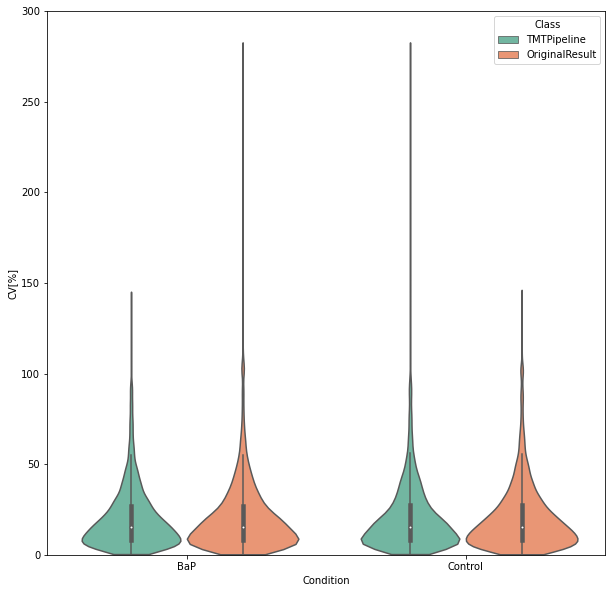

CV of TMTPipeline in BaP Condition: 15.400000
CV of Original in BaP Condition: 15.600000
CV of TMTPipeline in Control Condition: 15.600000
CV of Original in Control Condition: 15.600000


In [84]:
# How to Caculate CV !!!

from seaborn import violinplot, stripplot

data = pd.read_csv("./out_msstats_pre.csv", sep=",", header=0)
viodata = pd.DataFrame(columns=["Condition","CV[%]", "Class"])

BaPMedian = np.median(data[data["Condition"] == "BaP"]["Intensity"])
ControlMedian = np.median(data[data["Condition"] == "Control"]["Intensity"])

fillBaPMedian = {"BaP": BaPMedian, "Control": ControlMedian}
for condition in np.unique(data["Condition"]):
    sdata = data[data["Condition"] == condition]
    for name, group in sdata.groupby(["ProteinName"]):
        # Missed Value ?
        t = group["Intensity"]
#         if len(set(group["BioReplicate"])) < 6:
#             continue
#             t = group["Intensity"].tolist()
#             t.extend([fillBaPMedian[condition]] * (6 - len(set(group["BioReplicate"]))))
    
        std = np.std(t)
        mean = np.sum(group["Intensity"]) / 6
        if mean != 0.0:
            viodata = viodata.append({"Condition": condition, "CV[%]": round(std / mean, 3) * 100, "Class": "TMTPipeline"}, 
                                     ignore_index = True)

evidata = pd.read_csv("./evidence.txt", sep="\t", header=0)
evimedian = evidata["Reporter intensity corrected 1"].tolist()
evimedian.extend(evidata["Reporter intensity corrected 2"].tolist())
evimedian.extend(evidata["Reporter intensity corrected 3"].tolist())
evimedian = np.median(evimedian)

for name, group in evidata.groupby("Proteins"):
    
    # Missed Value ?
#     if len(set(group["Experiment"])) < 2:
#         continue
    t = group["Reporter intensity corrected 1"].tolist()
    t.extend(group["Reporter intensity corrected 2"].tolist())
    t.extend(group["Reporter intensity corrected 3"].tolist())
    std = np.std(t)
    mean = np.sum(t) / 6
    if mean != 0:
        viodata = viodata.append({"Condition": "BaP", "CV[%]": round(std / mean, 3) * 100, "Class": "OriginalResult"}, ignore_index = True)
        
    t = group["Reporter intensity corrected 4"].tolist()
    t.extend(group["Reporter intensity corrected 5"].tolist())
    t.extend(group["Reporter intensity corrected 6"].tolist())
    std = np.std(t)
    mean = np.sum(t) / 6
    if mean != 0:
        viodata = viodata.append({"Condition": "Control", "CV[%]": round(std / mean, 3) * 100, "Class": "OriginalResult"}, ignore_index = True)
        
plt.figure(figsize=(10,10))
violinplot(x="Condition", y="CV[%]", data=viodata, hue="Class", scale="count", cut=0, palette="Set2")
# stripplot(x="Condition", y="CV[%]", data=viodata[viodata["CV[%]"] > 150], jitter=0, color="c", hue="Class")

plt.ylim(0, 300)
plt.show()

print("CV of TMTPipeline in BaP Condition: %f" %(np.median(viodata[(viodata["Class"] == "TMTPipeline") & (viodata["Condition"] == "BaP")]["CV[%]"])))
print("CV of Original in BaP Condition: %f" %(np.median(viodata[(viodata["Class"] == "OriginalResult") & (viodata["Condition"] == "BaP")]["CV[%]"])))
print("CV of TMTPipeline in Control Condition: %f" %(np.median(viodata[(viodata["Class"] == "TMTPipeline") & (viodata["Condition"] == "Control")]["CV[%]"])))
print("CV of Original in Control Condition: %f" %(np.median(viodata[(viodata["Class"] == "OriginalResult") & (viodata["Condition"] == "Control")]["CV[%]"])))

### HeatMap

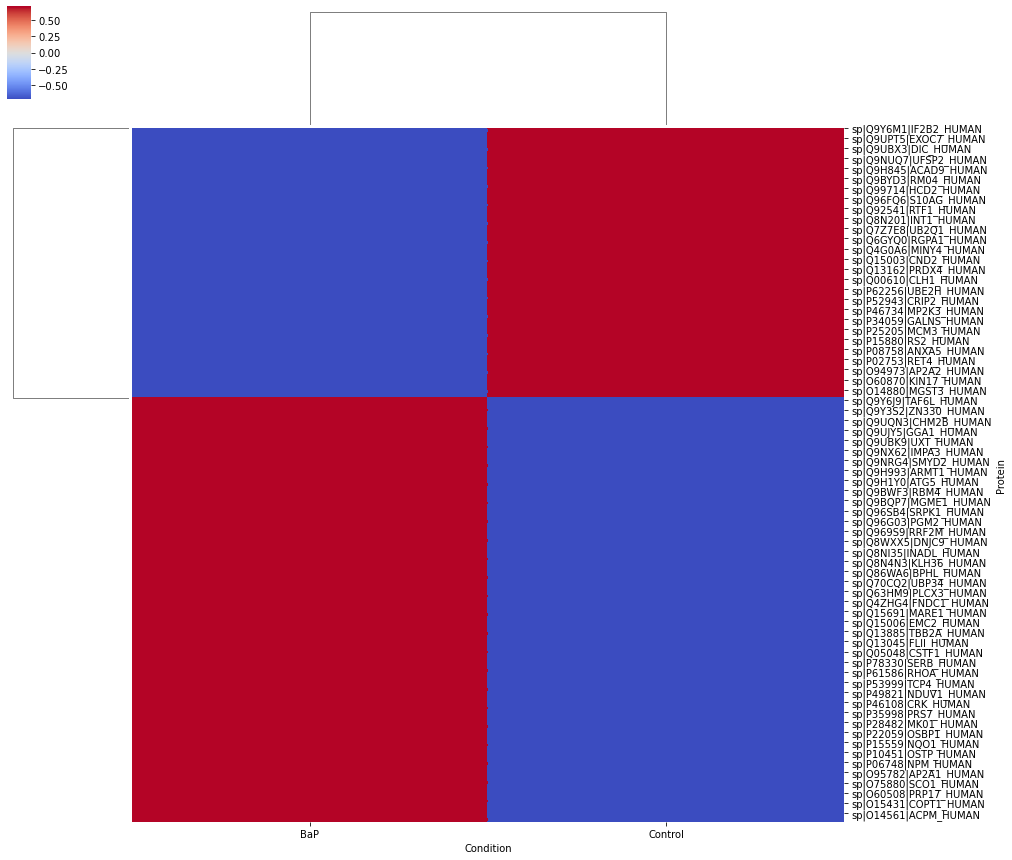

In [43]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = './protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()